First thing we need to notice is that the original dataset was divided into two regions : Bejaia and SidiBel each containing 122 instances.
Column meanings:
- **Date** : Date of the measurement
- **Temperature** : Temperature in Celsius (22 to 44)
- **RH** : Relative Humidity (21 to 90%)
- **Ws** : Wind speed (6 to 29 km/h)
- **Rain** : Total rain in the day (0 to 16.8 mm)

Then we have the FWI (Fire Weather Index) components. FWI is a classification system that uses the previous columns to determine the risk of fire. 
FWI (Fire Weather Index) column meanings:
- **FFMC** : Fine Fuel Moisture Code (28.6 to 92.5), which measures the moisture of fine combustibles on the forest floor
- **DMC** : Duff Moisture Code (1.1 to 65.9), which measures the moisture in the thickest materials
- **DC** : Drought Code (7.0 to 220.4), which measures the moisture in the soil
- **ISI** : Initial Spread Index (0.0 to 18.5), which measures the inital rate of fire spread
- **BUI** : Build Up Index (1.1 to 68.0), which measure the total amount of fuel available
- **FWI** : Fire Weather Index (0.0 to 31.1), which brings all the previous components together

Finally we have the **Classes** column which is the target variable. It represents wether or not a fire occured in the day.

In [12]:
#Defining Global Variables
DATA_PATH = 'data'
DATA_FILE = 'Algerian_forest_fires_dataset.csv'
DATA_FILE_BEJAIA = 'Bejaia_Region_Dataset.csv'
DATA_FILE_SIDIBEL = 'SidiBel_Region_Dataset.csv'

#Importing Libraries
import pandas as pd

The dataset contains 3 columns `day, month, year` which can be used to create a `Date` column.

It also contains columns with whitespaces in their names, which we will rename.

In [13]:
# read csv file
fire_data = pd.read_csv(f'{DATA_PATH}/{DATA_FILE}')
# create Date column
fire_data['Date'] = pd.to_datetime(fire_data[['day','month','year']].apply(lambda x: '/'.join(x.astype(str)),axis = 1), format='%d/%m/%Y')
# remove day, month and year columns
fire_data.drop(['day','month','year'], axis=1, inplace=True)
print(fire_data.head())

# get columns which have whitespaces in their names
fire_data.columns = fire_data.columns.str.replace(' ', '')
print(fire_data.columns)


   Temperature   RH   Ws  Rain   FFMC  DMC    DC  ISI  BUI  FWI    Classes    \
0           29   57   18    0.0  65.7  3.4   7.6  1.3  3.4  0.5  not fire      
1           29   61   13    1.3  64.4  4.1   7.6  1.0  3.9  0.4  not fire      
2           26   82   22   13.1  47.1  2.5   7.1  0.3  2.7  0.1  not fire      
3           25   89   13    2.5  28.6  1.3   6.9  0.0  1.7    0  not fire      
4           27   77   16    0.0  64.8  3.0  14.2  1.2  3.9  0.5  not fire      

        Date  
0 2012-06-01  
1 2012-06-02  
2 2012-06-03  
3 2012-06-04  
4 2012-06-05  
Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'FWI', 'Classes', 'Date'],
      dtype='object')


One of the first things to do is to identify if there are any missing values in the dataset. We can do this by using the `isnull()` function.

In [14]:
# check for missing values in the dataset
missing_values = fire_data.isnull() 
# print the rows that contains missing values
print(fire_data[missing_values.any(axis=1)])


     Temperature  RH  Ws  Rain  FFMC   DMC      DC   ISI   BUI      FWI  \
165           37  37  18   0.2  88.9  12.9  14.6 9  12.5  10.4  fire      

    Classes       Date  
165     NaN 2012-07-14  


We can see that the dataset contains one row with missing values. However, it is a delimiter problem. The missing value is actually in the same row as the column names, but instead of a `','` it has a `' '`. We will simply delete it and also check for duplicate instances.

In [15]:
# delete the row that has a missing value
error_rows = fire_data[missing_values.any(axis=1)]
# for each row in error_rows
for index, row in error_rows.iterrows():
    # get the date
    date = row['Date']
    # get the index of the row that has the same date
    index_to_delete = fire_data[fire_data['Date'] == date].index
    # delete the row
    fire_data.drop(index_to_delete, inplace=True)
# check if it was actually deleted
print(fire_data[missing_values.any(axis=1)])

# check for duplicates
fire_data.drop_duplicates(inplace=True)

Empty DataFrame
Columns: [Temperature, RH, Ws, Rain, FFMC, DMC, DC, ISI, BUI, FWI, Classes, Date]
Index: []


C:\Users\maysa\AppData\Local\Temp\ipykernel_2152\2337743853.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(fire_data[missing_values.any(axis=1)])


Next, it's always a good idea to look at the distribution of the data. We can do this by using the `describe()` function.

In [16]:
fire_data.describe()

,Temperature,RH,Ws,Rain,FFMC,DMC,ISI,BUI
count,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000,242.000000
mean,32.144628,62.045455,15.504132,0.763636,77.858678,14.709091,4.756198,16.724793
std,3.633602,14.858740,2.812609,2.007331,14.377130,12.410780,4.157249,14.247864
min,22.000000,21.000000,6.000000,0.000000,28.600000,0.700000,0.000000,1.100000
25%,30.000000,52.250000,14.000000,0.000000,71.625000,5.800000,1.400000,6.000000
50%,32.000000,63.000000,15.000000,0.000000,83.500000,11.300000,3.500000,12.450000
75%,35.000000,73.750000,17.000000,0.500000,88.300000,20.850000,7.275000,22.775000
max,42.000000,90.000000,29.000000,16.800000,96.000000,65.900000,19.000000,68.000000


Lets plot the distribution of each columng along the diagonal using scatterplots. Then we can plot a scatterplot matrix for the combination of each variable. It makes an efficient tool to look for errors in the data.

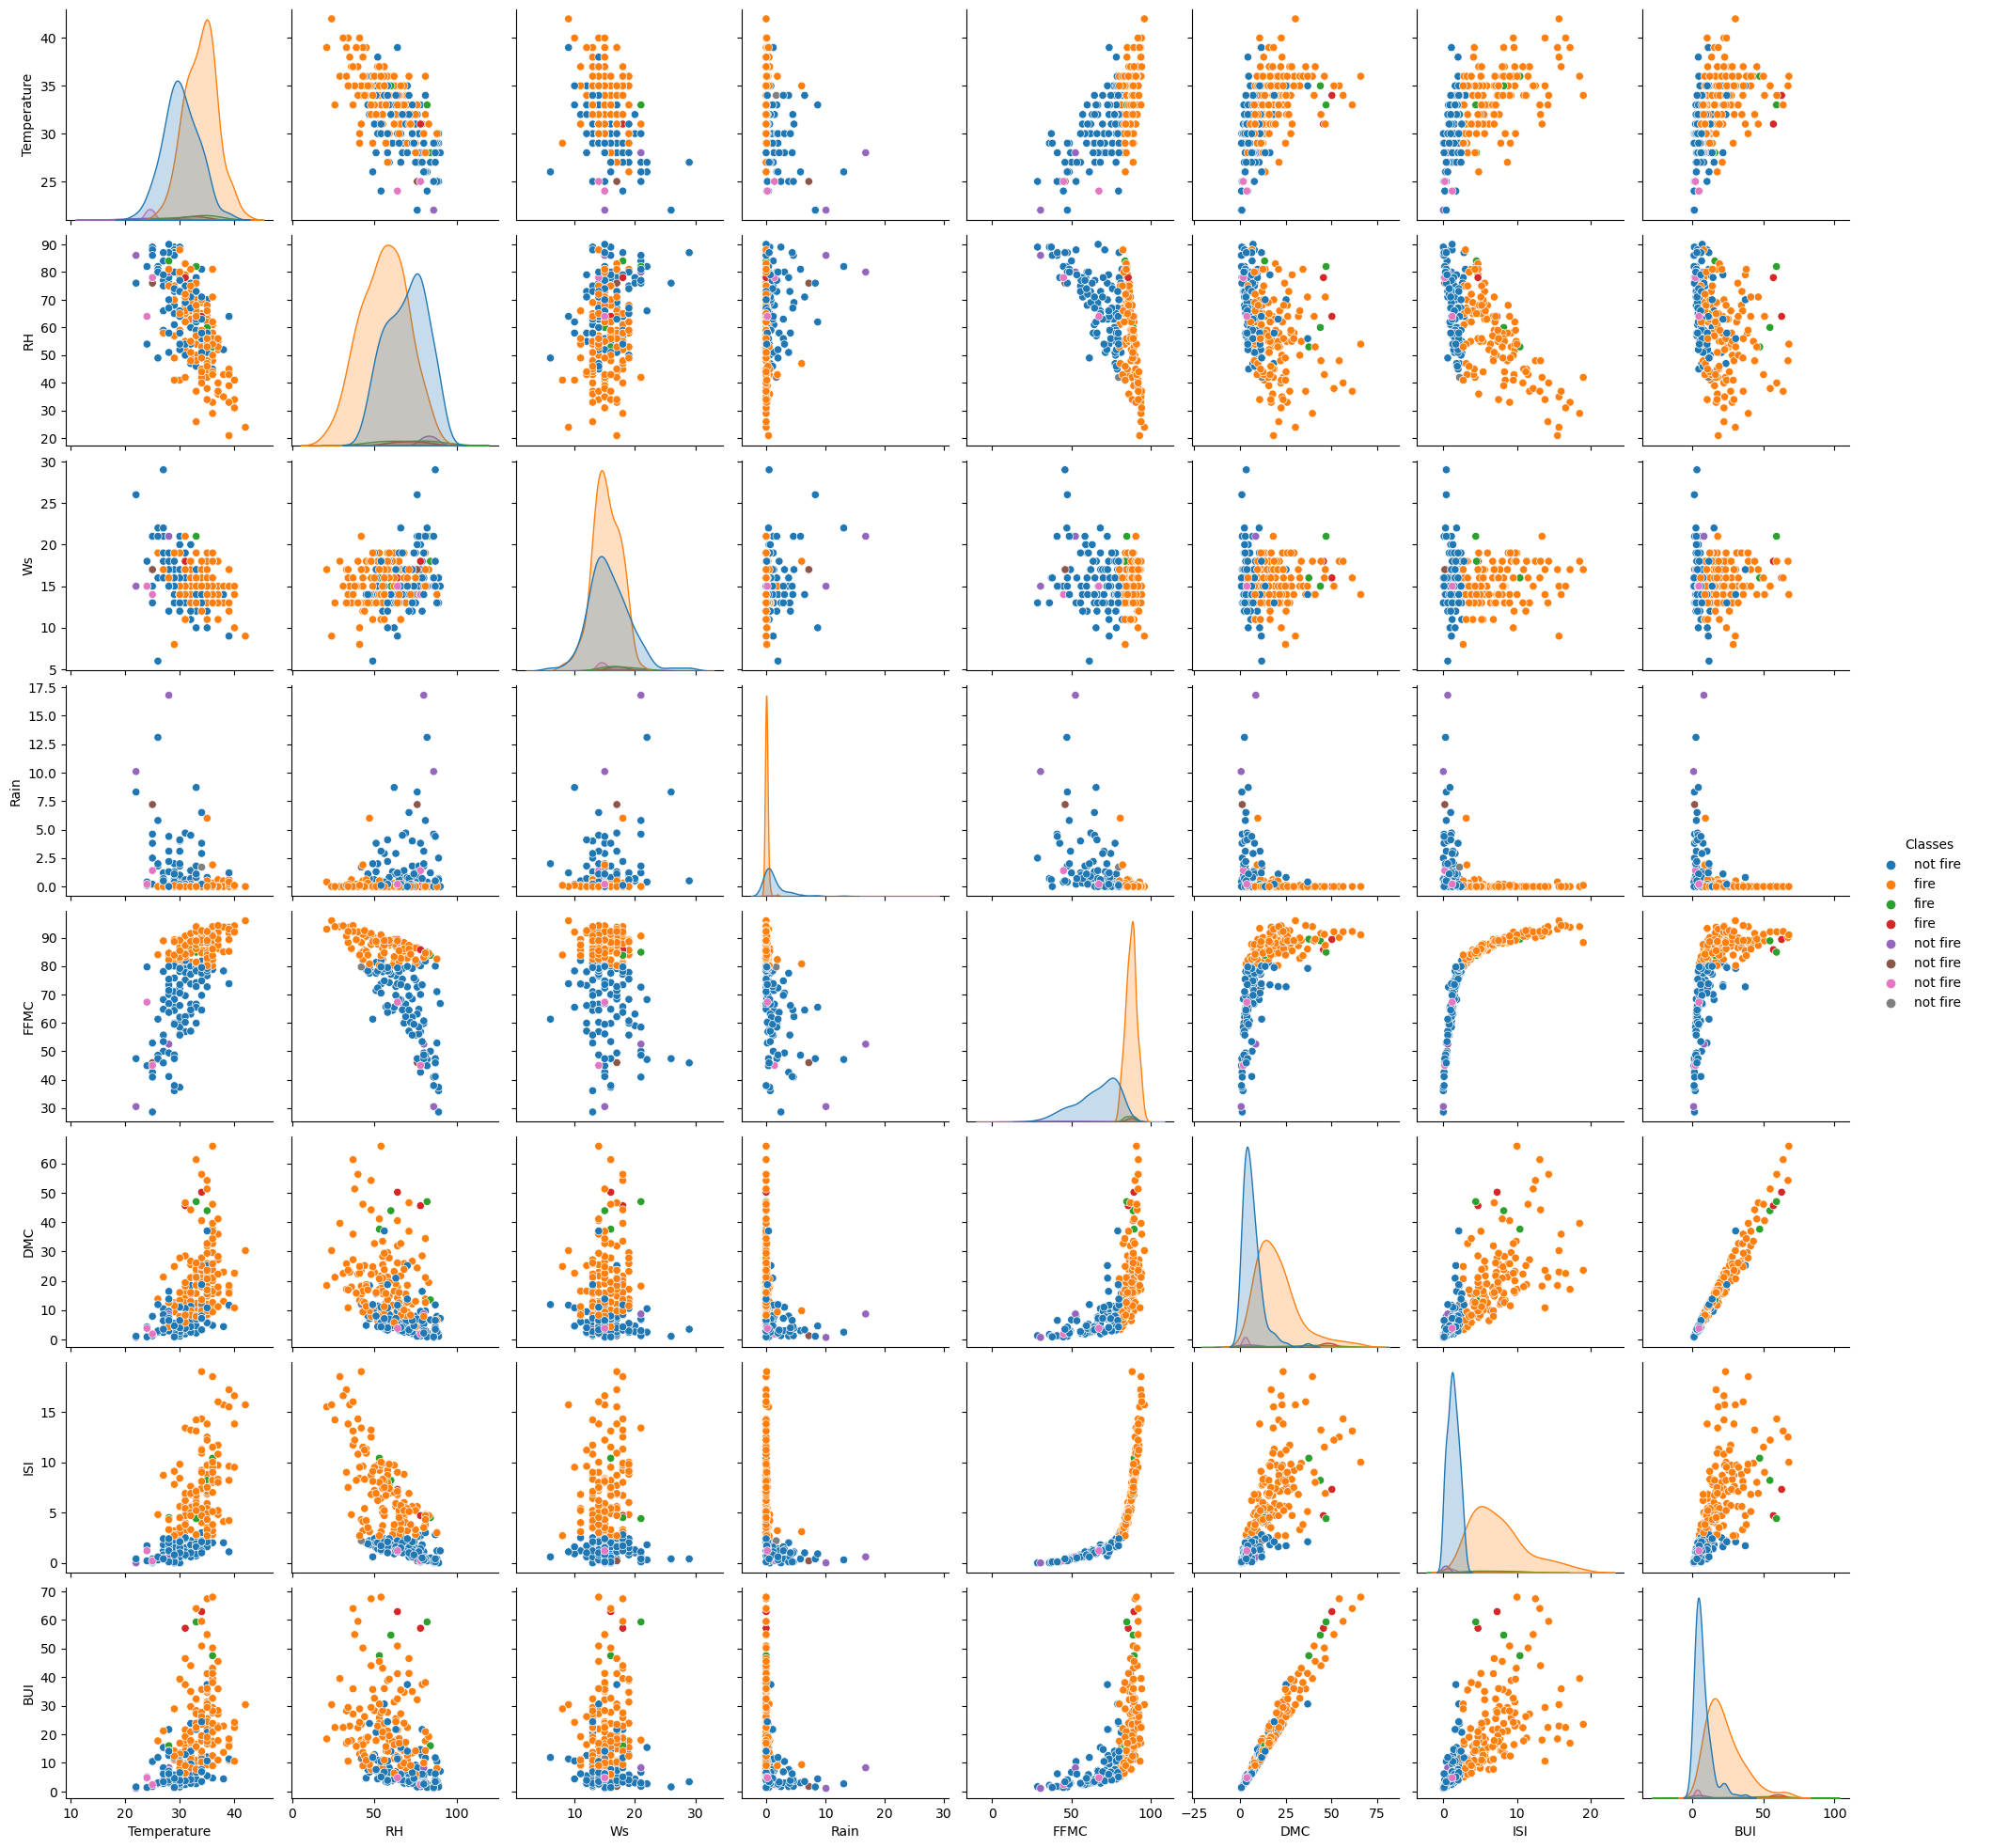

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb 

sb.pairplot(fire_data, hue ='Classes')

From this plot, we can see that there are 8 classes when it should only be 2.

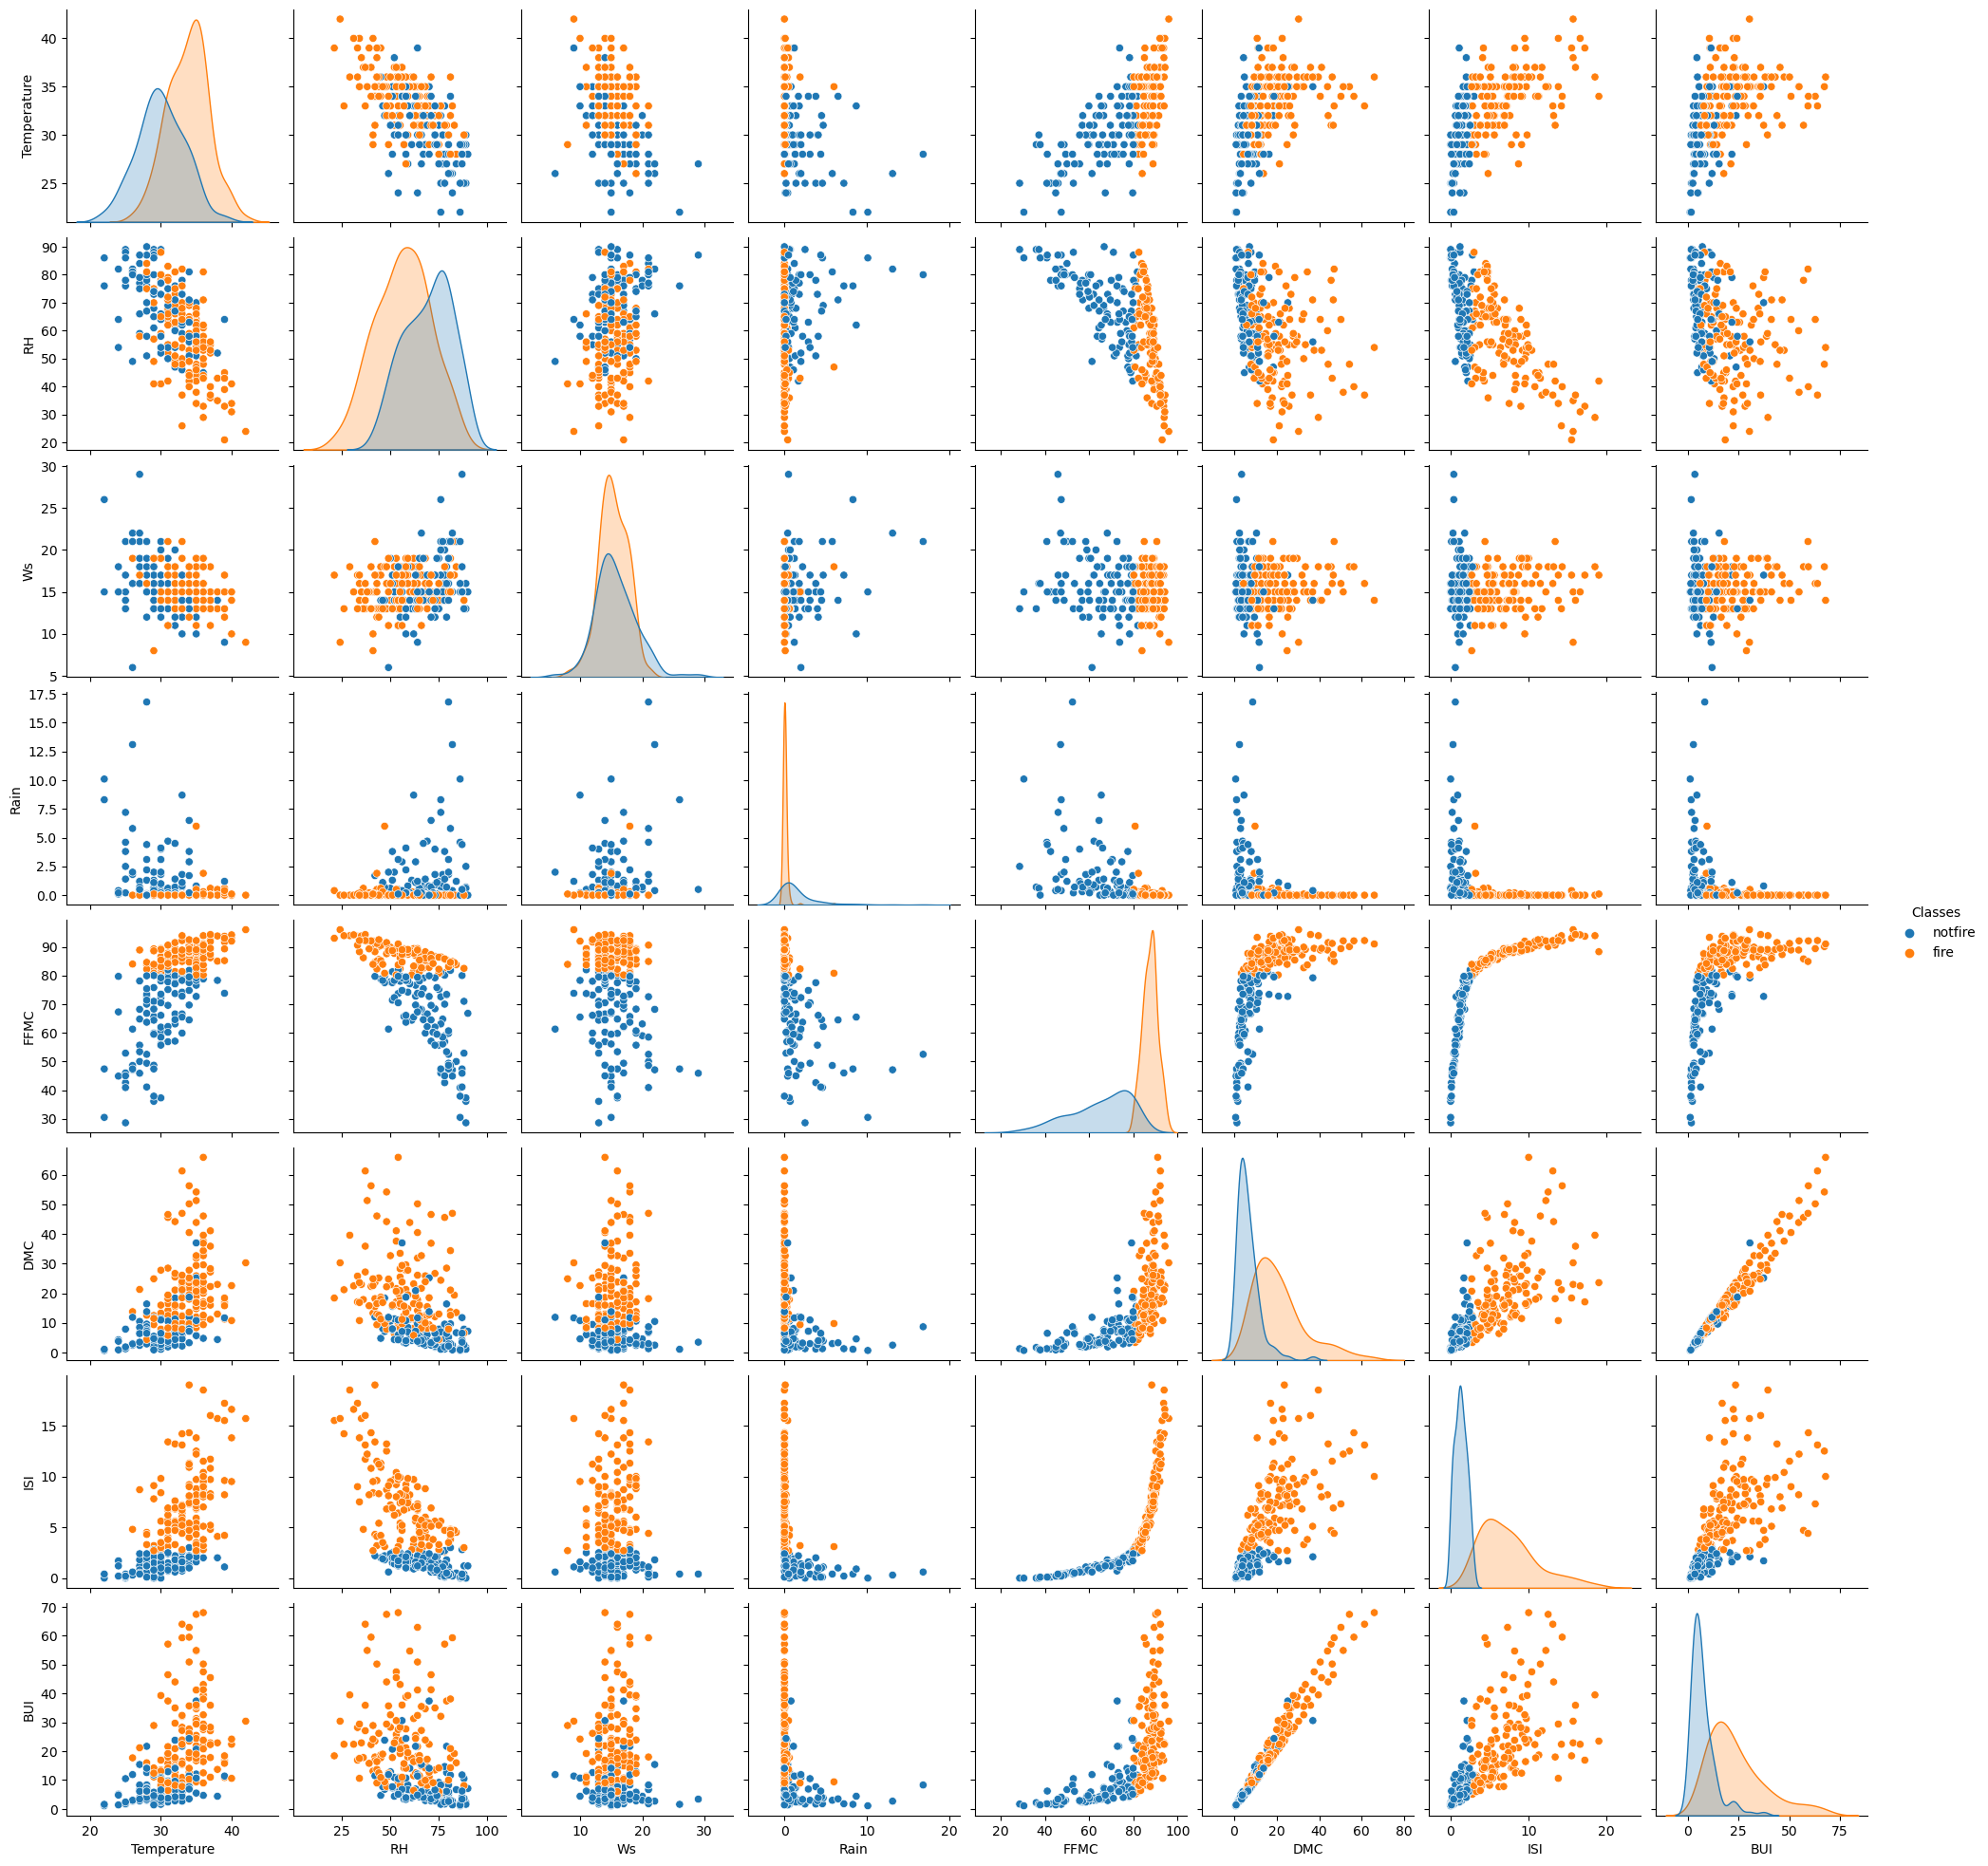

In [22]:
# replace the values of the column Classes remove the whitespaces
fire_data['Classes'] = fire_data['Classes'].str.replace(' ', '')
# now plot again 
sb.pairplot(fire_data, hue ='Classes')

Now that we have 2 classes, we can see that that is a tendency in the FWI components for the fire to occur. There is a clear separation between the two classes, where the left side is the `not fire` class and the right side is the `fire` class.

There are some outliers in the dataset, like the two `Ws` entries around 20-30 and the two `Rain` entries around 10-20, but we will not remove them because they are not errors. They are just extreme values and we think that they are a valuable information for the model.

The next phase is the exploratory data analysis. (...)